In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import mxnet as mx
from mxnet import nd
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet import autograd

import numpy as np
import pandas as pd

import logging
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
meta = pd.read_csv('data/TGGATES/cel/rat/meta.csv',index_col=0)

In [4]:
biochem = pd.read_csv('data/TGGATES/cel/rat/biochem.scaled.csv',index_col=0)

In [5]:
expr = pd.read_csv('data/TGGATES/cel/rat/exprs.scaled.csv',index_col=0)

In [6]:
len(set(meta['COMPOUND_NAME']))

158

In [7]:
biochem.shape,expr.shape,meta.shape

((2351, 19), (31099, 2459), (2459, 69))

In [8]:
common_groups = sorted(set(biochem.index) & set(expr.columns) & set(meta.index))
len(common_groups)

2351

In [9]:
expr = expr.loc[:,common_groups]

In [10]:
biochem = biochem.loc[common_groups,:]

In [11]:
meta = meta.loc[common_groups,:]

In [12]:
biochem.shape,expr.shape,meta.shape

((2351, 19), (31099, 2351), (2351, 69))

In [13]:
class simSampler(mx.gluon.data.Sampler):
    def __init__(self,input_coefs, output_coefs, batch_size=1, nbatches=1, mv_inputs=False, mv_outputs=False):
        self.input_coefs = input_coefs
        self.output_coefs = output_coefs
        self.batch_size = batch_size
        self.nbatches = nbatches
        self.mv_inputs = mv_inputs
        self.mv_outputs = mv_outputs
        
        if(mv_inputs):
            self.cov_inputs = np.cov(input_coefs.T)
        else:
            self.cov_inputs = None
        if(mv_outputs):
            self.cov_outputs = np.cov(output_coefs.T)
        else:
            self.cov_outputs = None
            
    def __len__(self):
        return self.nbatches
    
    def __iter__(self):
        for i in range(self.nbatches):
            idx = np.random.choice(np.arange(self.input_coefs.shape[0]),self.batch_size)

            if self.mv_inputs:
                input_sample = np.array([np.random.multivariate_normal(self.input_coefs[_,:],self.cov_inputs) for _ in idx])
            else:
                input_sample = np.random.normal(self.input_coefs[idx,:],1)

            if self.mv_outputs:
                output_sample = np.array([np.random.multivariate_normal(self.output_coefs[_,:],self.cov_outputs) for _ in idx])
            else:
                output_sample = mx.nd.array(np.random.normal(self.output_coefs[idx,:],1))

            yield mx.nd.array(input_sample),mx.nd.array(output_sample)
            
testsamp = simSampler(expr.values.T,biochem.values,10,3,False,True)
[(_[0].shape,_[1].shape) for _ in testsamp]

[((10, 31099), (10, 19)), ((10, 31099), (10, 19)), ((10, 31099), (10, 19))]

In [14]:
dat = pd.DataFrame(meta)

In [15]:
len(set(meta['COMPOUND_NAME']))

154

In [16]:
#test_compounds = ['vitamin A','ibuprofen','tamoxifen']
#test_compounds = ['ibuprofen','diazepam','acetamindofluorene']
np.random.seed(123)
test_compounds = np.random.choice(sorted(set(meta['COMPOUND_NAME'])),10,replace=False)
test_compounds

array(['ciprofloxacin', 'lornoxicam', 'rifampicin', 'bromobenzene',
       'nitrofurantoin', 'erythromycin ethylsuccinate', 'quinidine',
       'cimetidine', 'tetracycline', 'propylthiouracil'], dtype='<U31')

In [17]:
#val_compounds = ['ibuprofen','diazepam','acetamindofluorene']
np.random.seed(123)
val_compounds = np.random.choice(sorted(set(meta['COMPOUND_NAME'])-set(test_compounds)),10,replace=False)
val_compounds

array(['chlorpheniramine', 'bromoethylamine', 'phenytoin', 'naproxen',
       'chlormadinone', 'tacrine', 'ethambutol', 'cycloheximide',
       'ethionine', 'rotenone'], dtype='<U31')

In [18]:
test_idx = np.in1d(meta['COMPOUND_NAME'],test_compounds)
val_idx = np.in1d(meta['COMPOUND_NAME'],val_compounds)
train_idx = np.logical_and(np.logical_not(test_idx),np.logical_not(val_idx))

In [19]:
batch_size = 20
num_epochs = 10000

In [128]:
train_data = simSampler(expr.values.T[train_idx,:],biochem.values[train_idx,:],batch_size,num_epochs,False,True)
val_data = simSampler(expr.values.T[val_idx,:],biochem.values[val_idx,:],batch_size,num_epochs,False,True)
test_data = simSampler(expr.values.T[test_idx,:],biochem.values[test_idx,:],batch_size,num_epochs,False,True)
all_data = simSampler(expr.values.T,biochem.values,batch_size,num_epochs,False,True)

In [20]:
train_data = simSampler(biochem.values[train_idx,:],biochem.values[train_idx,:],batch_size,num_epochs,False,True)
val_data = simSampler(biochem.values[val_idx,:],biochem.values[val_idx,:],batch_size,num_epochs,False,True)
test_data = simSampler(biochem.values[test_idx,:],biochem.values[test_idx,:],batch_size,num_epochs,False,True)
all_data = simSampler(biochem.values,biochem.values,batch_size,num_epochs,False,True)

In [140]:
concat_data = np.hstack((expr.values.T,biochem.values))
train_data = simSampler(concat_data[train_idx,:],biochem.values[train_idx,:],batch_size,num_epochs,False,True)
val_data = simSampler(concat_data[val_idx,:],biochem.values[val_idx,:],batch_size,num_epochs,False,True)
test_data = simSampler(concat_data[test_idx,:],biochem.values[test_idx,:],batch_size,num_epochs,False,True)
all_data = simSampler(concat_data,biochem.values,batch_size,num_epochs,False,True)

In [21]:
simdata = list(simSampler(all_data.input_coefs,all_data.output_coefs,10000,1,False,False))[0]

## Restart here

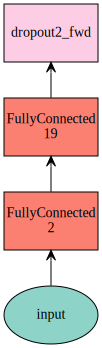

In [44]:
net = nn.HybridSequential()

net.add(
    nn.Dense(2),
    nn.Dense(biochem.shape[1]),
    nn.Dropout(.5)
)

net.initialize()

mse = gluon.loss.L2Loss()

#net(nd.array(biochem.values)).shape
#net(nd.array(expr.values.T)).shape

mx.viz.plot_network(net(mx.sym.var('input')))

In [45]:
trainer = gluon.Trainer(net.collect_params(), 'AdaGrad')

In [46]:
train_corrs = []
val_corrs = []

train_loss, train_acc, valid_acc = 0., 0., 0.
tic = time.time()
epoch = 0
for data, label in train_data:
    epoch += 1
    # forward + backward
    with autograd.record():
        output = net(data)
        loss = mse(output, label)
    loss.backward()
    # update parameters
    trainer.step(batch_size)
    if epoch % (train_data.nbatches/100) == 0:
        # calculate training metrics
        train_corr = np.corrcoef(train_data.output_coefs.flatten(),net(mx.nd.array(train_data.input_coefs)).asnumpy().flatten())[0,1]
        val_corr = np.corrcoef(val_data.output_coefs.flatten(),net(mx.nd.array(val_data.input_coefs)).asnumpy().flatten())[0,1]
        print("Epoch %d: train corr %.3f, validation corr %.3f, in %.1f sec" % (epoch, train_corr, val_corr, time.time()-tic))
        train_corrs.append(train_corr)
        val_corrs.append(val_corr)
        
test_corr = np.corrcoef(test_data.output_coefs.flatten(),net(mx.nd.array(test_data.input_coefs)).asnumpy().flatten())[0,1]
print("Test corr %.3f" % (test_corr))


Epoch 100: train corr 0.482, validation corr 0.384, in 0.8 sec
Epoch 200: train corr 0.497, validation corr 0.387, in 1.5 sec
Epoch 300: train corr 0.502, validation corr 0.386, in 2.2 sec
Epoch 400: train corr 0.506, validation corr 0.390, in 2.9 sec
Epoch 500: train corr 0.507, validation corr 0.392, in 3.6 sec
Epoch 600: train corr 0.508, validation corr 0.395, in 4.3 sec
Epoch 700: train corr 0.509, validation corr 0.397, in 5.1 sec
Epoch 800: train corr 0.509, validation corr 0.398, in 5.8 sec
Epoch 900: train corr 0.509, validation corr 0.398, in 6.5 sec
Epoch 1000: train corr 0.509, validation corr 0.399, in 7.2 sec
Epoch 1100: train corr 0.510, validation corr 0.401, in 7.9 sec
Epoch 1200: train corr 0.510, validation corr 0.400, in 8.7 sec
Epoch 1300: train corr 0.510, validation corr 0.399, in 9.4 sec
Epoch 1400: train corr 0.511, validation corr 0.399, in 10.1 sec
Epoch 1500: train corr 0.512, validation corr 0.401, in 10.8 sec
Epoch 1600: train corr 0.512, validation corr 0

Text(0, 0.5, 'Pearson correlation')

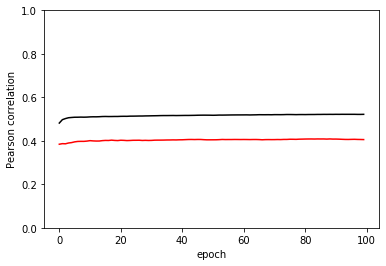

In [47]:
plt.plot(range(len(train_corrs)),train_corrs,label='train',color='k')
plt.plot(range(len(val_corrs)),val_corrs,label='val',color='r')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('Pearson correlation')

In [48]:
simdatapreds = net(simdata[0]).asnumpy()

Text(0, 0.5, 'predicted endpoint value')

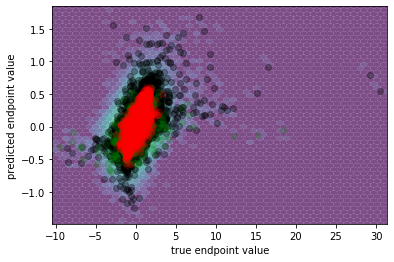

In [30]:
plt.hexbin(simdata[1].asnumpy().flatten(),simdatapreds.flatten(),gridsize=50,linewidths=0,alpha=.7,bins='log')
plt.scatter(train_data.output_coefs.flatten(),net(mx.nd.array(train_data.input_coefs)).asnumpy().flatten(),alpha=.3,color='k',label='train')
plt.scatter(val_data.output_coefs.flatten(),net(mx.nd.array(val_data.input_coefs)).asnumpy().flatten(),alpha=.2,color='g',label='val')
plt.scatter(test_data.output_coefs.flatten(),net(mx.nd.array(test_data.input_coefs)).asnumpy().flatten(),alpha=.2,color='r',label='test')
plt.xlabel('true endpoint value')
plt.ylabel('predicted endpoint value')

Text(0, 0.5, 'predicted endpoint value')

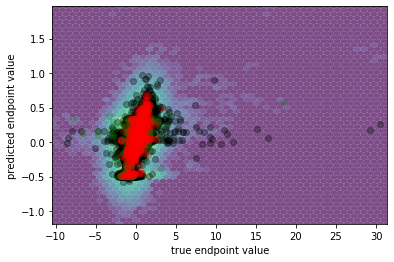

In [49]:
plt.hexbin(simdata[1].asnumpy().flatten(),simdatapreds.flatten(),gridsize=50,linewidths=0,alpha=.7,bins='log')
plt.scatter(train_data.output_coefs.flatten(),net(mx.nd.array(train_data.input_coefs)).asnumpy().flatten(),alpha=.3,color='k',label='train')
plt.scatter(val_data.output_coefs.flatten(),net(mx.nd.array(val_data.input_coefs)).asnumpy().flatten(),alpha=.2,color='g',label='val')
plt.scatter(test_data.output_coefs.flatten(),net(mx.nd.array(test_data.input_coefs)).asnumpy().flatten(),alpha=.2,color='r',label='test')
plt.xlabel('true endpoint value')
plt.ylabel('predicted endpoint value')

In [50]:
pca_extract_orig = net[0](mx.nd.array(all_data.input_coefs)).asnumpy()
pca_extract = net[0](simdata[0]).asnumpy()

In [51]:
dat['PC1'] = pd.Series(pca_extract_orig[:,0], index=dat.index)
dat['PC2'] = pd.Series(pca_extract_orig[:,1], index=dat.index)

In [52]:
dat.head()

,BARCODE,ARR_DESIGN,EXP_ID,GROUP_ID,INDIVIDUAL_ID,ORGAN_ID,MATERIAL_ID,COMPOUND_NAME,COMPOUND.Abbr.,COMPOUND_NO,...,ALT.IU.L.,LDH.IU.L.,GTP.IU.L.,DNA...,LDH...,CEL,combn,HOURS,PC1,PC2
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,42,85,0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,0.655895,-0.880766
"combnLiver.2,4-dinitrophenol.6.24 hr",3017865029,Rat230_2,672,8,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,34,107,0,NaN,NaN,003017865029.CEL,"Liver.2,4-dinitrophenol.6.24 hr",24,0.906729,-0.861055
"combnLiver.2,4-dinitrophenol.20.24 hr",3017866002,Rat230_2,672,12,3,Liver,A,"2,4-dinitrophenol",DNP,154,...,52,110,1,NaN,NaN,003017866002.CEL,"Liver.2,4-dinitrophenol.20.24 hr",24,0.957989,-0.872220
"combnLiver.2,4-dinitrophenol.60.24 hr",3017866005,Rat230_2,672,16,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,28,131,1,NaN,NaN,003017866005.CEL,"Liver.2,4-dinitrophenol.60.24 hr",24,1.461679,-1.242770
combnLiver.2-nitrofluorene.0.24 hr,3017911030,Rat230_2,712,1,2,Liver,A,2-nitrofluorene,2NF,160,...,48,132,0.7,NaN,NaN,003017911030.CEL,Liver.2-nitrofluorene.0.24 hr,24,-0.648868,0.507213


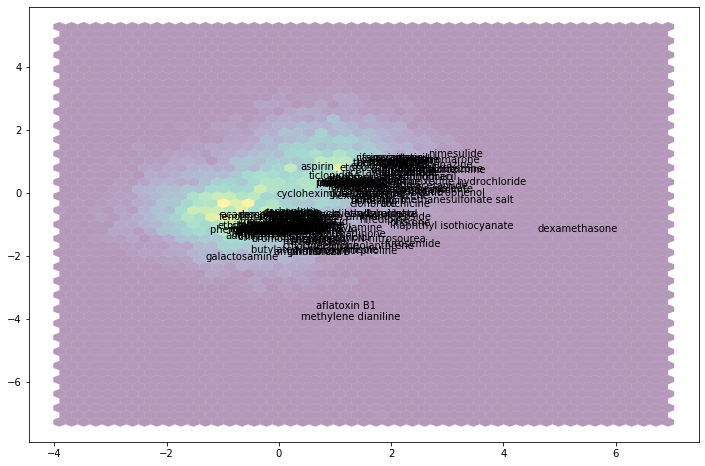

In [34]:
plt.figure(figsize=(12,8))

plt.hexbin(pca_extract[:,0],pca_extract[:,1],gridsize=50,linewidths=0,alpha=.4)

for genotype, genotypeGroup in dat.groupby('ORGAN_ID'):
    for trt, treatmentGroup in genotypeGroup.groupby('COMPOUND_NAME'):
        plt.text(treatmentGroup['PC1'].mean()+treatmentGroup['PC1'].std(),treatmentGroup['PC2'].mean()-treatmentGroup['PC2'].std(),trt)
#plt.legend()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


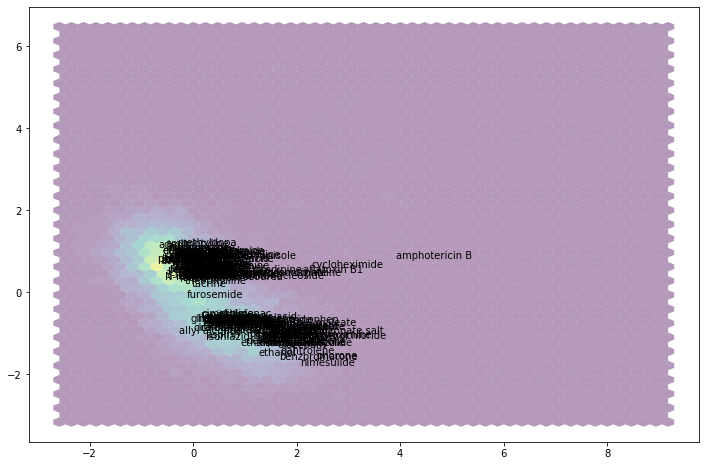

In [53]:
plt.figure(figsize=(12,8))

plt.hexbin(pca_extract[:,0],pca_extract[:,1],gridsize=50,linewidths=0,alpha=.4)

for genotype, genotypeGroup in dat.groupby('ORGAN_ID'):
    for trt, treatmentGroup in genotypeGroup.groupby('COMPOUND_NAME'):
        plt.text(treatmentGroup['PC1'].mean()+treatmentGroup['PC1'].std(),treatmentGroup['PC2'].mean()-treatmentGroup['PC2'].std(),trt)
#plt.legend()

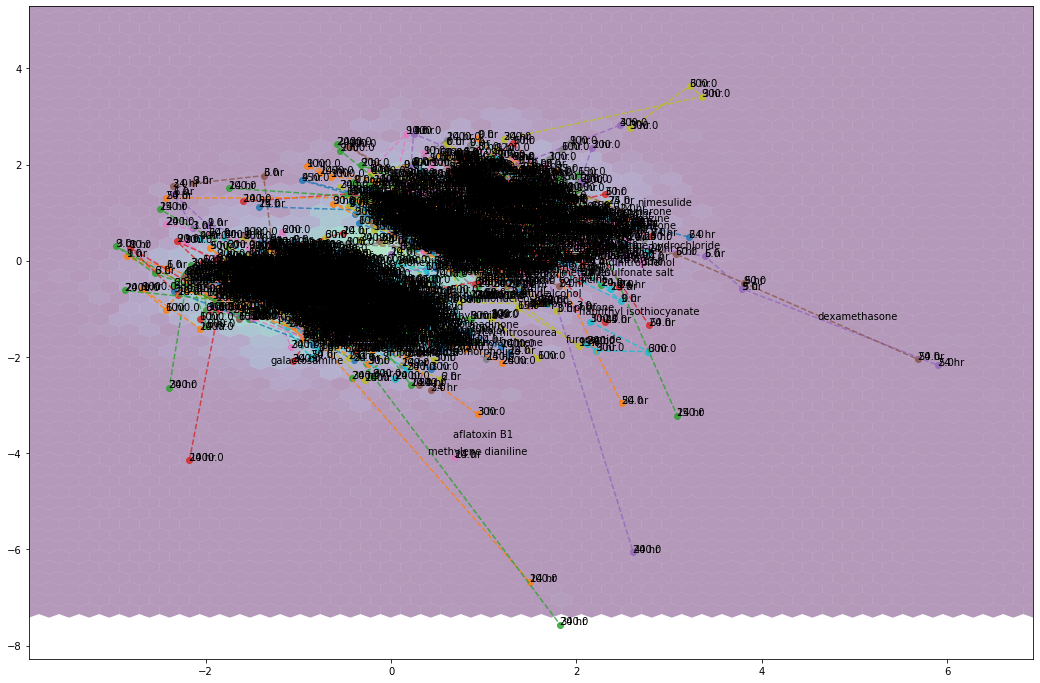

In [35]:
plt.figure(figsize=(18,12))

plt.hexbin(pca_extract[:,0],pca_extract[:,1],gridsize=50,linewidths=0,alpha=.4)

for genotype, genotypeGroup in dat.groupby('ORGAN_ID'):
    for trt, treatmentGroup in genotypeGroup.groupby('COMPOUND_NAME'):
        plt.text(treatmentGroup['PC1'].mean()+treatmentGroup['PC1'].std(),treatmentGroup['PC2'].mean()-treatmentGroup['PC2'].std(),trt)
        for tp, timeGroup in treatmentGroup.groupby('SACRI_PERIOD'):
            timeGroup = timeGroup.sort_values('DOSE')
            for dose, doseGroup in timeGroup.groupby('DOSE'):
                plt.text(doseGroup['PC1'],doseGroup['PC2'],dose)
        for dose, doseGroup in treatmentGroup.groupby('DOSE'):
            doseGroup = doseGroup.sort_values('HOURS')
            plt.plot(doseGroup['PC1'],doseGroup['PC2'],label='',linestyle='--',alpha=.8)
            plt.scatter(doseGroup['PC1'],doseGroup['PC2'],label=dose,alpha=.8)
            for tp, timeGroup in doseGroup.groupby('SACRI_PERIOD'):
                plt.text(timeGroup['PC1'],timeGroup['PC2'],tp)
#plt.legend()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


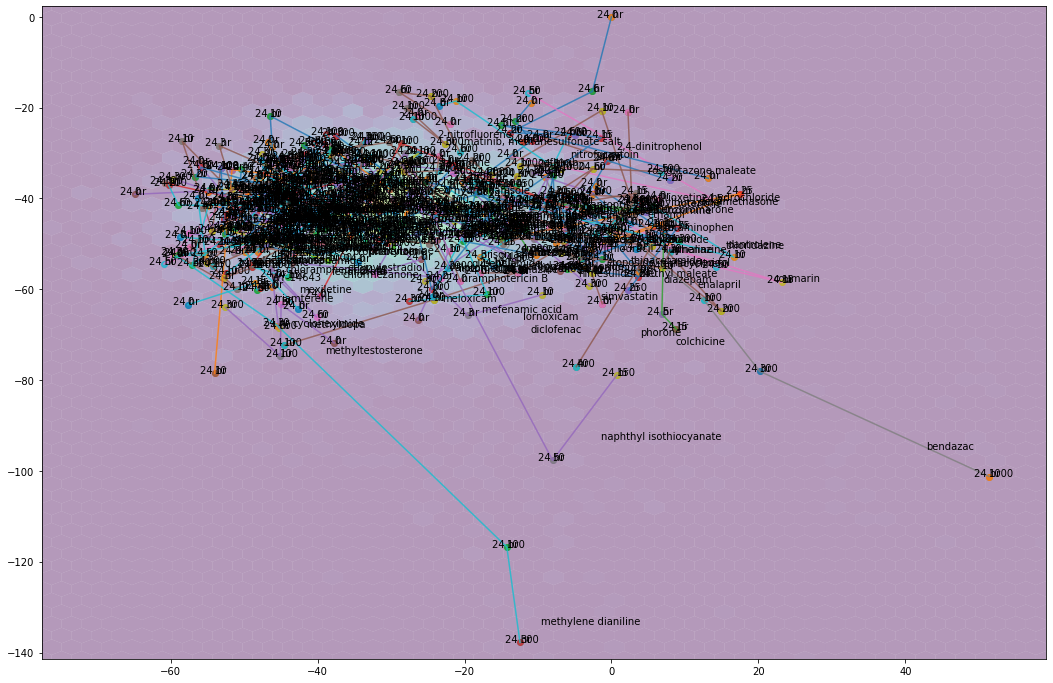

In [136]:
plt.figure(figsize=(18,12))

plt.hexbin(pca_extract[:,0],pca_extract[:,1],gridsize=50,linewidths=0,alpha=.4)

for genotype, genotypeGroup in dat.groupby('ORGAN_ID'):
    for trt, treatmentGroup in genotypeGroup.groupby('COMPOUND_NAME'):
        plt.text(treatmentGroup['PC1'].mean()+treatmentGroup['PC1'].std(),treatmentGroup['PC2'].mean()-treatmentGroup['PC2'].std(),trt)
        for tp, timeGroup in treatmentGroup.groupby('SACRI_PERIOD'):
            timeGroup = timeGroup.sort_values('DOSE')
            plt.plot(timeGroup['PC1'],timeGroup['PC2'],label='',alpha=.8)
            plt.scatter(timeGroup['PC1'],timeGroup['PC2'],label=tp,alpha=.8)
            for dose, doseGroup in timeGroup.groupby('DOSE'):
                plt.text(doseGroup['PC1'],doseGroup['PC2'],dose)
        for dose, doseGroup in treatmentGroup.groupby('DOSE'):
            doseGroup = doseGroup.sort_values('HOURS')
            plt.plot(doseGroup['PC1'],doseGroup['PC2'],label='',linestyle='--',alpha=.8)
            plt.scatter(doseGroup['PC1'],doseGroup['PC2'],label=dose,alpha=.8)
            for tp, timeGroup in doseGroup.groupby('SACRI_PERIOD'):
                plt.text(timeGroup['PC1']-2,timeGroup['PC2'],tp)
#plt.legend()

In [36]:
inputs_tp0 = []
outputs_tp1 = []
doseGroups = []
sample_pairs = []
for genotype, genotypeGroup in meta.groupby('ORGAN_ID'):
    for trt, treatmentGroup in genotypeGroup.groupby('COMPOUND_NAME'):
        for dose, doseGroup in treatmentGroup.groupby('DOSE'):
            doseGroup = doseGroup.sort_values('HOURS')
            tp0_idx = 0 #an early timepoint
            tp1_idx = -1 #last timepoint (24 h)
            tp0_nidx = np.where(meta.index==doseGroup.index[tp0_idx])[0][0]
            tp1_nidx = np.where(meta.index==doseGroup.index[tp1_idx])[0][0]
            doseGroups.append(pd.DataFrame(doseGroup.iloc[tp1_idx,:]).T)
            inputs_tp0.append(all_data.input_coefs[tp0_nidx,:])
            outputs_tp1.append(all_data.output_coefs[tp1_nidx,:])
            sample_pairs.append((doseGroup.index[tp0_idx],doseGroup.index[tp1_idx]))
inputs_tp0 = np.array(inputs_tp0)
outputs_tp1 = np.array(outputs_tp1)

In [37]:
dat = pd.concat(doseGroups)
dat.shape

(600, 71)

In [38]:
inputs_tp0.shape,outputs_tp1.shape

((600, 19), (600, 19))

In [39]:
testsamp = simSampler(inputs_tp0,outputs_tp1,10,3,False,True)
[(_[0].shape,_[1].shape) for _ in testsamp]

[((10, 19), (10, 19)), ((10, 19), (10, 19)), ((10, 19), (10, 19))]

In [40]:
test_idx = np.in1d(dat['COMPOUND_NAME'],test_compounds)
val_idx = np.in1d(dat['COMPOUND_NAME'],val_compounds)
train_idx = np.logical_and(np.logical_not(test_idx),np.logical_not(val_idx))

In [41]:
train_data = simSampler(inputs_tp0[train_idx,:],outputs_tp1[train_idx,:],batch_size,num_epochs,False,True)
val_data = simSampler(inputs_tp0[val_idx,:],outputs_tp1[val_idx,:],batch_size,num_epochs,False,True)
test_data = simSampler(inputs_tp0[test_idx,:],outputs_tp1[test_idx,:],batch_size,num_epochs,False,True)
all_data = simSampler(inputs_tp0,outputs_tp1,batch_size,num_epochs,False,True)

In [42]:
import gc

In [43]:
gc.collect()

421972

## Go up to model creation and rerun with time-series data simulation

In [54]:
design = pd.read_csv('data/TGGATES/cel/rat/exprs.design.csv',index_col=0)

In [55]:
design

,"combnLiver.2,4-dinitrophenol.0.3 hr",combnLiver.2-nitrofluorene.0.24 hr,combnLiver.2-nitrofluorene.100.24 hr,combnLiver.2-nitrofluorene.1000.24 hr,combnLiver.2-nitrofluorene.300.24 hr,"combnLiver.2,4-dinitrophenol.0.24 hr","combnLiver.2,4-dinitrophenol.0.6 hr","combnLiver.2,4-dinitrophenol.0.9 hr","combnLiver.2,4-dinitrophenol.20.24 hr","combnLiver.2,4-dinitrophenol.20.3 hr",...,combnLiver.WY-14643.10.6 hr,combnLiver.WY-14643.10.9 hr,combnLiver.WY-14643.100.24 hr,combnLiver.WY-14643.100.3 hr,combnLiver.WY-14643.100.6 hr,combnLiver.WY-14643.100.9 hr,combnLiver.WY-14643.30.24 hr,combnLiver.WY-14643.30.3 hr,combnLiver.WY-14643.30.6 hr,combnLiver.WY-14643.30.9 hr
003017001013.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017001014.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017001015.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017001001.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017001002.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
003017959012.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017959013.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017959014.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003017959015.CEL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
expr_fitted = pd.read_csv('data/TGGATES/cel/rat/exprs.fitted.csv',index_col=0)

In [57]:
expr_fitted

,003017001013.CEL,003017001014.CEL,003017001015.CEL,003017001001.CEL,003017001002.CEL,003017001003.CEL,003017001004.CEL,003017001005.CEL,003017001006.CEL,003017001010.CEL,...,003017959019.CEL,003017959008.CEL,003017959009.CEL,003017959010.CEL,003017959011.CEL,003017959012.CEL,003017959013.CEL,003017959014.CEL,003017959015.CEL,003017959016.CEL
AFFX-BioB-5_at,0.016886,0.334044,-0.350930,-0.313871,0.580482,-0.266611,-0.185445,-0.256025,0.441471,0.460450,...,0.073833,-0.150178,0.094860,0.055318,-0.152700,-0.004576,0.157276,-0.112293,-0.010273,0.122566
AFFX-BioB-M_at,-0.218698,0.527135,-0.308437,-0.260277,0.359269,-0.098992,-0.153388,-0.288803,0.442191,0.388333,...,0.220504,-0.099535,0.082718,0.016817,-0.095616,0.036671,0.058945,-0.040090,0.050391,-0.010301
AFFX-BioB-3_at,-0.356068,0.644961,-0.288893,-0.051536,0.492870,-0.441334,-0.162370,-0.391859,0.554229,0.415512,...,0.263031,-0.167132,0.203014,-0.035882,-0.052661,0.037569,0.015092,-0.118706,0.136072,-0.017366
AFFX-BioC-5_at,-0.267208,0.623153,-0.355945,-0.248362,0.360310,-0.111948,-0.091519,-0.393699,0.485218,0.667182,...,0.291208,-0.181793,0.189225,-0.007432,-0.121399,0.033031,0.088369,-0.011803,0.106566,-0.094763
AFFX-BioC-3_at,-0.258404,0.670424,-0.412021,-0.400799,0.587868,-0.187069,0.038195,-0.565911,0.527716,0.801694,...,0.288292,-0.011707,0.023544,-0.011837,-0.161144,0.129769,0.031375,-0.191860,0.099948,0.091911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398744_at,-0.075787,0.153037,-0.077250,0.011386,-0.255522,0.244136,0.530603,-0.527676,-0.002927,0.362860,...,-0.743174,-0.195761,1.119681,-0.923921,-0.003736,0.314212,-0.310476,1.006513,-0.856700,-0.149813
1398745_at,-0.067913,0.091311,-0.023398,-0.414864,0.101384,0.313480,0.113234,-0.128022,0.014788,0.392008,...,0.322608,-0.948157,-0.055066,1.003223,-0.279782,0.182950,0.096833,-0.490391,0.192758,0.297634
1398746_at,0.020436,0.510929,-0.531364,0.323997,-0.460739,0.136741,0.727339,-1.027441,0.300102,-0.357287,...,0.288697,0.180773,0.048641,-0.229414,0.629158,-0.130771,-0.498387,-0.209528,0.295955,-0.086427
1398747_at,0.232308,0.240272,-0.472580,0.023820,-0.111569,0.087749,0.469563,0.409833,-0.879396,0.759694,...,0.416687,-0.031663,-0.525504,0.557167,-0.237062,0.493527,-0.256465,0.414804,-0.688718,0.273914


In [58]:
biochem_fitted = pd.read_csv('data/TGGATES/cel/rat/biochem.fitted.csv',index_col=0)

In [59]:
biochem_fitted

,ALP.IU.L.,TC.mg.dL.,TG.mg.dL.,PL.mg.dL.,GLC.mg.dL.,BUN.mg.dL.,CRE.mg.dL.,Na.meq.L.,K.meq.L.,Cl.meq.L.,Ca.mg.dL.,IP.mg.dL.,TP.g.dL.,RALB.g.dL.,A.G,AST.IU.L.,ALT.IU.L.,LDH.IU.L.,GTP.IU.L.
003017911030.CEL,0.093360,-1.065005,1.985938,0.482316,0.825588,0.955969,-0.166658,-1.245959,-1.732096,-0.885033,2.365590,-1.550816,-0.408947,-0.874291,-0.751957,-0.010187,0.153102,0.585631,-0.794729
003017912001.CEL,0.590854,0.927573,0.774608,0.860472,0.887935,0.982758,-1.220313,-0.028517,-0.045181,0.354513,0.835425,-2.244300,0.945933,-1.667674,-1.479857,0.309781,1.956728,0.711357,-0.644837
003017912002.CEL,-1.013905,-0.729980,2.310868,2.464334,0.263695,0.831757,-0.837607,-0.838168,0.545303,0.084504,0.406227,-1.923849,-1.736844,-1.375424,0.053752,0.241453,0.412146,0.120456,-0.047797
003017912003.CEL,1.446322,-0.206368,0.602196,-0.556206,-0.410046,0.053026,-0.054949,-0.974150,-0.413586,-0.085661,1.620092,-1.894175,-1.449261,-0.127920,-0.083424,0.826374,0.087872,0.966464,-0.836915
003017912004.CEL,1.975766,-0.475029,1.305279,-0.128989,0.340095,0.794220,-2.153549,-0.224556,1.081152,-0.231797,0.289156,-1.929103,0.523857,-0.571407,-1.300085,0.151765,2.178271,1.343488,-1.106847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
003017688018.CEL,0.793395,0.991693,2.259743,1.042400,-0.344893,-0.742957,-1.382149,-0.525473,0.459505,0.545405,0.733298,2.228708,-1.223688,-2.706073,-0.466042,0.045916,-0.967819,0.715848,1.452887
003017688019.CEL,-0.720683,0.373267,0.239292,-0.863917,0.528634,-0.346540,-0.596407,-0.519270,0.339432,0.091985,1.133624,0.467220,-0.697552,-1.671314,-0.470845,-0.359225,0.098898,-0.355242,-0.955934
003017689007.CEL,-0.293091,1.486939,0.811650,0.483721,0.895119,-0.382372,-0.707438,-0.617912,-0.460695,-0.038822,-1.903070,2.267354,0.432956,-0.232971,-1.237730,-0.170796,-0.348617,0.835715,-0.145711
003017689008.CEL,2.377743,-1.690089,0.937787,-0.832205,1.242615,-0.511236,-1.350009,0.250800,0.063253,0.136351,0.552016,1.478470,-0.745721,-1.763754,-0.212682,0.679494,-1.404623,0.614589,1.411731


In [60]:
common_cels = sorted(set(design.index) & set(expr_fitted.columns) & set(biochem_fitted.index))
len(common_cels)

7054

In [62]:
design = design.loc[common_cels,:]
expr_fitted = expr_fitted.loc[:,common_cels]
biochem_fitted = biochem_fitted.loc[common_cels,:]

In [63]:
expr_tp0 = np.vstack([expr_fitted.iloc[:,(design.loc[:,sample_pair[0]]>0).values].values.T for sample_pair in sample_pairs])
expr_tp0.shape

(1802, 31099)

In [64]:
biochem_tp0 = np.hstack([biochem_fitted.iloc[(design.loc[:,sample_pair[0]]>0).values,:].values.T for sample_pair in sample_pairs]).T
biochem_tp0.shape

(1802, 19)

In [65]:
inputs_tp0 = pd.DataFrame(biochem_tp0)

In [66]:
names_idx = []
for sample_pair in sample_pairs:
    for _ in range((design.loc[:,sample_pair[0]]>0).sum()):
        names_idx.append(sample_pair[1])
names_idx = np.array(names_idx)
names_tp1 = meta.loc[names_idx,:]
names_tp1

,BARCODE,ARR_DESIGN,EXP_ID,GROUP_ID,INDIVIDUAL_ID,ORGAN_ID,MATERIAL_ID,COMPOUND_NAME,COMPOUND.Abbr.,COMPOUND_NO,...,ALT.IU.L.,LDH.IU.L.,GTP.IU.L.,DNA...,LDH...,CEL,combn,HOURS,PC1,PC2
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,42,85,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,42,85,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,42,85,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824
"combnLiver.2,4-dinitrophenol.6.24 hr",3017865029,Rat230_2,672,8,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,34,107,0.0,NaN,NaN,003017865029.CEL,"Liver.2,4-dinitrophenol.6.24 hr",24,1.805281,0.353353
"combnLiver.2,4-dinitrophenol.6.24 hr",3017865029,Rat230_2,672,8,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,34,107,0.0,NaN,NaN,003017865029.CEL,"Liver.2,4-dinitrophenol.6.24 hr",24,1.805281,0.353353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
combnLiver.vitamin A.30.24 hr,3017057006,Rat230_2,281,12,1,Liver,A,vitamin A,VA,59,...,46,242,1.0,NaN,NaN,003017057006.CEL,Liver.vitamin A.30.24 hr,24,0.186849,-1.396264
combnLiver.vitamin A.30.24 hr,3017057006,Rat230_2,281,12,1,Liver,A,vitamin A,VA,59,...,46,242,1.0,NaN,NaN,003017057006.CEL,Liver.vitamin A.30.24 hr,24,0.186849,-1.396264
combnLiver.vitamin A.100.24 hr,3017057009,Rat230_2,281,16,1,Liver,A,vitamin A,VA,59,...,45,341,2.0,NaN,NaN,003017057009.CEL,Liver.vitamin A.100.24 hr,24,0.461239,-1.738853
combnLiver.vitamin A.100.24 hr,3017057009,Rat230_2,281,16,1,Liver,A,vitamin A,VA,59,...,45,341,2.0,NaN,NaN,003017057009.CEL,Liver.vitamin A.100.24 hr,24,0.461239,-1.738853


In [67]:
names_tp1.shape

(1802, 71)

In [68]:
pca_extract_tp0 = net[0](mx.nd.array(inputs_tp0)).asnumpy()
pca_extract_tp0.shape

(1802, 2)

In [69]:
names_tp1['PC1_pred'] = pca_extract_tp0[:,0]
names_tp1['PC2_pred'] = pca_extract_tp0[:,1]

In [70]:
names_tp1

,BARCODE,ARR_DESIGN,EXP_ID,GROUP_ID,INDIVIDUAL_ID,ORGAN_ID,MATERIAL_ID,COMPOUND_NAME,COMPOUND.Abbr.,COMPOUND_NO,...,GTP.IU.L.,DNA...,LDH...,CEL,combn,HOURS,PC1,PC2,PC1_pred,PC2_pred
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824,0.828784,-0.963682
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824,0.470237,-1.647362
"combnLiver.2,4-dinitrophenol.0.24 hr",3017865026,Rat230_2,672,4,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,0.0,NaN,NaN,003017865026.CEL,"Liver.2,4-dinitrophenol.0.24 hr",24,1.905785,-0.032824,0.554441,0.106196
"combnLiver.2,4-dinitrophenol.6.24 hr",3017865029,Rat230_2,672,8,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,0.0,NaN,NaN,003017865029.CEL,"Liver.2,4-dinitrophenol.6.24 hr",24,1.805281,0.353353,0.860015,-1.533538
"combnLiver.2,4-dinitrophenol.6.24 hr",3017865029,Rat230_2,672,8,1,Liver,A,"2,4-dinitrophenol",DNP,154,...,0.0,NaN,NaN,003017865029.CEL,"Liver.2,4-dinitrophenol.6.24 hr",24,1.805281,0.353353,0.341296,-1.085104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
combnLiver.vitamin A.30.24 hr,3017057006,Rat230_2,281,12,1,Liver,A,vitamin A,VA,59,...,1.0,NaN,NaN,003017057006.CEL,Liver.vitamin A.30.24 hr,24,0.186849,-1.396264,-0.380946,2.300643
combnLiver.vitamin A.30.24 hr,3017057006,Rat230_2,281,12,1,Liver,A,vitamin A,VA,59,...,1.0,NaN,NaN,003017057006.CEL,Liver.vitamin A.30.24 hr,24,0.186849,-1.396264,-0.242231,-0.160554
combnLiver.vitamin A.100.24 hr,3017057009,Rat230_2,281,16,1,Liver,A,vitamin A,VA,59,...,2.0,NaN,NaN,003017057009.CEL,Liver.vitamin A.100.24 hr,24,0.461239,-1.738853,0.079295,0.007954
combnLiver.vitamin A.100.24 hr,3017057009,Rat230_2,281,16,1,Liver,A,vitamin A,VA,59,...,2.0,NaN,NaN,003017057009.CEL,Liver.vitamin A.100.24 hr,24,0.461239,-1.738853,-1.127937,0.850338


In [71]:
names_tp1.to_csv('data/TGGATES/cel/rat/pred.pca.csv')

In [72]:
pred_tp0 = net(mx.nd.array(inputs_tp0)).asnumpy()
pred_tp0.shape

(1802, 19)

In [73]:
names_pred_tp1 = pd.concat((names_tp1,pd.DataFrame(pred_tp0,columns=biochem.columns,index=names_tp1.index)),axis=1)

In [74]:
names_pred_tp1.to_csv('data/TGGATES/cel/rat/pred.biochem.csv')